In [1]:
from models.cos_rootnohist_glm import Cos_RootNoHist_GLM
from models.cos_roothist_glm import Cos_RootHist_GLM


import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 500
device = torch.device("cuda")
batch_size = 100000
iter_no = 10000
epoch_no = 15
lr = 0.0005

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)

V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)
sub_no = C_den.shape[0]

In [4]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Cos_RootNoHist_GLM(C_den=C_den,
                         T_no=T_no,
                         greedy=False,
                         C_syn_e=C_syn_e,
                         C_syn_i=C_syn_i,
                         device = device)

optimizer = torch.optim.Adam([
            {'params': model.parameters()},
            ], lr = lr)

model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

220


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, sub_pred, out_filters = model.test_forward(batch_E_neural,
                                                         batch_I_neural)
    #train_score = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      #y_pred=V_pred.cpu().detach().numpy())
    
    loss = torch.var(batch_V - V_pred)
    loss.backward()
    optimizer.step()
    
    #print(train_score)
    
    if (i%500 == 499) or (i == iter_no-1):
        model.eval()
            
        test_V_pred, test_sub_pred, out_filters = model.test_forward(test_E_neural,test_I_neural)
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        
        print(i, test_score, torch.mean(test_sub_pred).item())

<ipython-input-6-8cb790beea0f>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


499 0.2993176579475403 0.2198488712310791
999 0.339713454246521 0.13007012009620667
1499 0.3481026291847229 0.04117996618151665
1999 0.3527836203575134 -0.022222217172384262
2499 0.3558233380317688 -0.06975872069597244
2999 0.3592180609703064 -0.10800822079181671
3499 0.36001724004745483 -0.1379166543483734
3999 0.3613932728767395 -0.14175820350646973
4499 0.3600590229034424 -0.14423693716526031
4999 0.36025387048721313 -0.14272306859493256
5499 0.3615727424621582 -0.1416807770729065
5999 0.3616185784339905 -0.14110226929187775
6499 0.36087876558303833 -0.1428077518939972
6999 0.3612985610961914 -0.1417662799358368
7499 0.3612556457519531 -0.14024871587753296
7999 0.3608531951904297 -0.1407165676355362
8499 0.36082834005355835 -0.13999515771865845
8999 0.36042511463165283 -0.13836511969566345
9499 0.36061161756515503 -0.13941161334514618
9999 0.36065781116485596 -0.1387825310230255



In [ ]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[20000:25000])
plt.plot(test_V_pred.cpu().detach().numpy()[20000:25000])
#plt.ylim(0,10)
#EXP + EXP

In [8]:
true = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[T_train:T_train+T_test]
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]
new = old + test_V_pred.cpu().detach().numpy()

0.9141887469103781 0.914616685262335


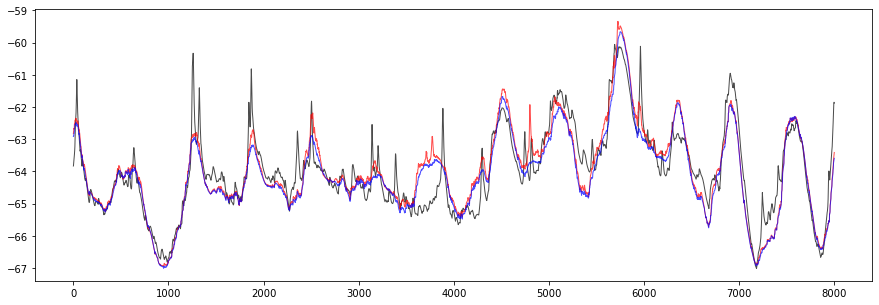

In [9]:
plt.figure(figsize=(15,5))
plt.plot(true[17000:25000], c="black", alpha=0.7, linewidth=1)
plt.plot(new[17000:25000], c="red", alpha=0.7, linewidth=1)
plt.plot(old[17000:25000], c="blue", alpha=0.7, linewidth=1)

new_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=new)
old_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=old)

print(old_score, new_score)